# Understanding segmentation in Deep Photo Style Transfer

This notebook is to investigate how to limit the scope of style transfer to only those areas that are in the 
selected segmentation maps.

It seems currently that the code is applying style transfer to all areas of the image.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
style_image_path = './examples/Manchester_low_res/future_style.jpg'
content_image_path = './examples/Manchester_low_res/new_buildings_1.jpeg'

In [3]:
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image

import matplotlib.pyplot as plt

import argparse

# ------custom module----
import config
import utils

sys.path.append('seg')
from seg.segmentation import *
from model import *
from merge_index import *

* Compute Laplacian matrix of content image

In [5]:
# style_image_path = args["style_image"]
# content_image_path = args["content_image"]

#-------------------------
print('Computing Laplacian matrix of content image')
L = utils.compute_lap(content_image_path)
print()


Computing Laplacian matrix of content image



* Compute masks

In [19]:
def gen_mask(image_path):
    """
    Generate semantic mask
    """
    seg_result = segmentation(image_path).squeeze(0)
    channel, height_, width_ = seg_result.size()
    
    for classes in merge_classes:
        for index, each_class in enumerate(classes):
            if index == 0:
                zeros_index = each_class
                base_map = seg_result[each_class, :, :].clone()
            else:
                # This merges the seg maps for classes to be merged! (Simple eh?!)
                base_map = base_map | seg_result[each_class, :, :]
        # And stores it an the index of the first item (0th position) in the list
        seg_result[zeros_index, :, :] = base_map
    
    return seg_result, height_, width_

In [86]:
#-------------------------
print('Merge the similar semantic mask')
style_mask_origin, height_, width_ = gen_mask(style_image_path)
content_mask_origin, height2, width2 = gen_mask(content_image_path)

Merge the similar semantic mask
Loading weights for net_encoder
Loading weights for net_decoder
# samples: 1
Loading weights for net_encoder
Loading weights for net_decoder
# samples: 1


* Now remove the unwanted classes (from del_classes) and those with less than 50 pixels!

In [87]:
merged_style_mask = np.zeros((117, height_, width_), dtype='int')
merged_content_mask = np.zeros((117, height2, width2), dtype='int')
print()

count = 0
for i in range(150):
    temp = style_mask_origin[i, :, :].numpy()
    if i not in del_classed and np.sum(temp)>50:
        print(count, np.sum(temp))
        merged_style_mask[count, :, :] = temp
        merged_content_mask[count, :, :] = content_mask_origin[i, :, :].numpy()
        count += 1
    else:
        pass
print('Total semantic classes in style image: {}'.format(count))
style_mask_tensor = torch.from_numpy(merged_style_mask[:count, :, :]).float().to(config.device0)
content_mask_tensor = torch.from_numpy(merged_content_mask[:count, :, :]).float().to(config.device0)


0 34822
1 104984
2 45671
3 18228
4 969
5 3717
6 103
Total semantic classes in style image: 7


Save each mask as an image for debugging
content_img size:  torch.Size([1, 3, 700, 525])


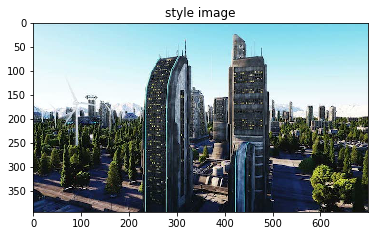

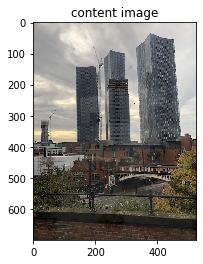

In [89]:
#--------------------------

#--------------------------
print('Save each mask as an image for debugging')
for i in range(count):
    utils.save_pic( torch.stack([style_mask_tensor[i, :, :], style_mask_tensor[i, :, :], style_mask_tensor[i, :, :]], dim=0), 
                                'style_mask_' + str(i) )
    utils.save_pic( torch.stack([content_mask_tensor[i, :, :], content_mask_tensor[i, :, :], content_mask_tensor[i, :, :]], dim=0), 
                                'content_mask_' + str(i) )

# Using GPU or CPU
device = torch.device(config.device0)

style_img = utils.load_image(style_image_path, None)
content_img = utils.load_image(content_image_path, None)
width_s, height_s = style_img.size
width_c, height_c = content_img.size

# print(height_s, width_s)
# print(height_c, width_c)

style_img = utils.image_to_tensor(style_img).unsqueeze(0)
content_img = utils.image_to_tensor(content_img).unsqueeze(0)

style_img = style_img.to(device, torch.float)
content_img = content_img.to(device, torch.float)

print('content_img size: ', content_img.size())
utils.show_pic(style_img, 'style image')
utils.show_pic(content_img, 'content image')




* View masks

In [90]:
# for i in range(count):
#     utils.show_pic( torch.stack([content_mask_tensor[i, :, :], content_mask_tensor[i, :, :], content_mask_tensor[i, :, :]], dim=0), 
#                                 'content_mask_' + str(i) )

In [91]:
# for i in range(count):
#     utils.show_pic( torch.stack([style_mask_tensor[i, :, :], style_mask_tensor[i, :, :], style_mask_tensor[i, :, :]], dim=0), 
#                                 'style_mask_' + str(i) )

* Force mask for content image

In [92]:
content_mask_path = './examples/segmentation/new_buildings_mask.png'
content_mask = utils.load_image(content_mask_path, None).convert('LA')
print(content_mask.size)
content_mask_tensor[0] = utils.image_to_tensor(content_mask)[0].unsqueeze(0).to(device, torch.float)
print(content_mask_tensor.shape)

(525, 700)
torch.Size([7, 700, 525])


In [106]:
style_mask_path = './examples/Manchester_low_res/future_style_mask_0.png'
style_mask = utils.load_image(style_mask_path, None).convert('LA')
print(style_mask.size)
style_mask_tensor[0] = utils.image_to_tensor(style_mask)[0].unsqueeze(0).to(device, torch.float)
print(style_mask_tensor.shape)

(700, 395)
torch.Size([1, 395, 700])


* Truncate masks to only be the ones we want

In [107]:
content_mask_tensor = content_mask_tensor[0].unsqueeze(0)
style_mask_tensor = style_mask_tensor[0].unsqueeze(0)

In [108]:
print('content_mask_tensor.shape={}'.format(content_mask_tensor.shape))
print('style_mask_tensor.shape={}'.format(style_mask_tensor.shape))
count = 1
print('Revised segmentation count = {}'.format(count))

content_mask_tensor.shape=torch.Size([1, 700, 525])
style_mask_tensor.shape=torch.Size([1, 395, 700])
Revised segmentation count = 1


* Show final masks!

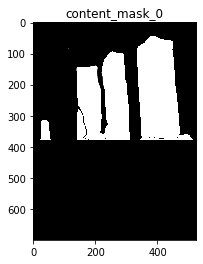

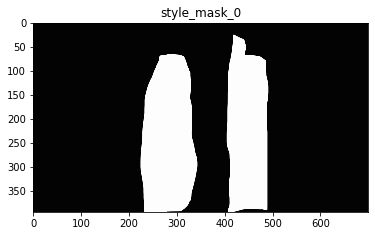

In [109]:
for i in range(count):
    utils.show_pic( torch.stack([content_mask_tensor[i, :, :], content_mask_tensor[i, :, :], content_mask_tensor[i, :, :]], dim=0), 
                                'content_mask_' + str(i) )
for i in range(count):
    utils.show_pic( torch.stack([style_mask_tensor[i, :, :], style_mask_tensor[i, :, :], style_mask_tensor[i, :, :]], dim=0), 
                                'style_mask_' + str(i) )

* Set up the CNN

In [110]:
# -------------------------
# Eval() means the parameters of cnn are frozen.
cnn = models.vgg19(pretrained=True).features.to(config.device0).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(config.device0)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(config.device0)

* Style transfer

In [ ]:
# Two different initialization ways
# input_img = torch.randn(1, 3, height_c, width_c).to(config.device0)
input_img = content_img.clone()
# print('input_img size: ', input_img.size())
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,
                            style_mask_tensor, content_mask_tensor, L)

Buliding the style transfer model..
xixi:  torch.Size([1, 3, 700, 525])
Optimizing...
********************
Style_weith: 1000000 Content_weighti: 100            TV_loss_weight: 0.0001 Realistic_loss_weight: 1
********************
run [50]/3000:
Style Loss: 255.106018 Content Loss: 273.813019 TV Loss: 31.968718 real loss: 0.000000
Total Loss:  560.8877563476562
run [100]/3000:
Style Loss: 174.424683 Content Loss: 220.245697 TV Loss: 32.225033 real loss: 0.000000
Total Loss:  426.8954162597656
run [150]/3000:
Style Loss: 152.954590 Content Loss: 200.142288 TV Loss: 31.033493 real loss: 0.000000
Total Loss:  384.13037109375
run [200]/3000:
Style Loss: 142.334442 Content Loss: 189.448853 TV Loss: 29.194094 real loss: 0.000000
Total Loss:  360.9773864746094
run [250]/3000:
Style Loss: 136.607391 Content Loss: 183.487122 TV Loss: 27.274862 real loss: 0.000000
Total Loss:  347.369384765625
run [300]/3000:
Style Loss: 133.754562 Content Loss: 180.521133 TV Loss: 25.389450 real loss: 0.000000
To

* Save best output

In [85]:
print('Style transfer completed')
utils.save_pic(output, 'deep_style_tranfer')
print()

#--------------------------
print('Postprocessing......')
utils.post_process(output, content_image_path)
print('Done!')

Style transfer completed

Postprocessing......


/home/mark_strefford/.conda/envs/pytorch1.0/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


0.8403245186463688
0.8851011014487384
Done!
